# 1. 강의영상 

<https://youtu.be/playlist?list=PLQqh36zP38-zwhGQx-SVKqORNSrWm0TYi&si=igNDnZPiKmBIpvlx>

# 2. Imports 

In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn.linear_model 
import sklearn.tree
import sklearn.model_selection

# 3. 예비학습 

In [7]:
df = pd.DataFrame({'X1':[2,3,4,1],'X2':['A','B','A','C']})
df 

X1 X2
0   2  A
1   3  B
2   4  A
3   1  C

In [8]:
pd.get_dummies(df)

X1   X2_A   X2_B   X2_C
0   2   True  False  False
1   3  False   True  False
2   4   True  False  False
3   1  False  False   True

- X2_A, X2_B, X2_C는 셋다 있을 필요는 없지 않나? --> 공선성문제가 생길수도 있음. 

In [9]:
pd.get_dummies(df,drop_first=True)

X1   X2_B   X2_C
0   2  False  False
1   3   True  False
2   4  False  False
3   1  False   True

# 4. Data 

`-` load 

In [13]:
np.random.seed(43052)
temp = pd.read_csv('https://raw.githubusercontent.com/guebin/DV2022/master/posts/temp.csv').iloc[:,3].to_numpy()[:100]
temp.sort()
choco = 40 + temp * 2.0 + np.random.randn(100)*3
vanilla = 60 + temp * 5.0 + np.random.randn(100)*3
df1 = pd.DataFrame({'temp':temp,'sales':choco}).assign(type='choco')
df2 = pd.DataFrame({'temp':temp,'sales':vanilla}).assign(type='vanilla')
df_train = pd.concat([df1,df2])
df_train

temp       sales     type
0   -4.1   32.950261    choco
1   -3.7   35.852524    choco
2   -3.0   37.428335    choco
3   -1.3   38.323681    choco
4   -0.5   39.713362    choco
..   ...         ...      ...
95  12.4  119.708075  vanilla
96  13.4  129.300464  vanilla
97  14.7  136.596568  vanilla
98  15.0  136.213140  vanilla
99  15.2  135.595252  vanilla

[200 rows x 3 columns]

`-` 시각화 및 해석 

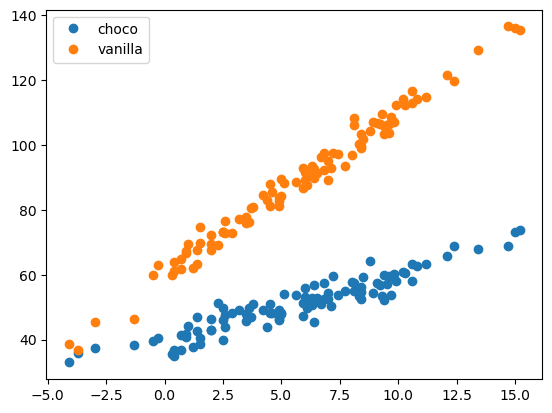

In [18]:
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales,'o',label='choco')
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales,'o',label='vanilla')
plt.legend()

- 온도에 따른 아이스크림 판매량이 아이스크림의 tpye에 따라 동일하다면 기울기가 동일하고 절편이 다른 두 직선이 나올것임. 
- 하지만 현재는 초코보다 바닐라맛이 기온의 영향을 많이 받아보임 $\to$ (바닐라아이스크림,온도)는 (초코아이스크림,온도)보다 궁합이 좋다. $\to$ 아이스크림 type과 온도사이에는 교호작용이 존재한다. 

# 5. 분석1

`-` 분석1: 모형을 아래와 같이 본다. 

- ${\bf X}$: `temp`, `type`
- ${\bf y}$: `sales`

In [20]:
# step1 
X,y = pd.get_dummies(df_train[['temp','type']],drop_first=True), df_train['sales']
# step2
predictr = sklearn.linear_model.LinearRegression()
# step3
predictr.fit(X,y)
# step4 
df_train['sales_hat'] = predictr.predict(X)

In [21]:
predictr.score(X,y)

0.9249530603100549

- 점수가 잘나왔다고 너무 좋아하지 마세요. 
- 시각화를 반드시 해보고 더 맞출수 있는 여지가 있는지 항상 확인할 것

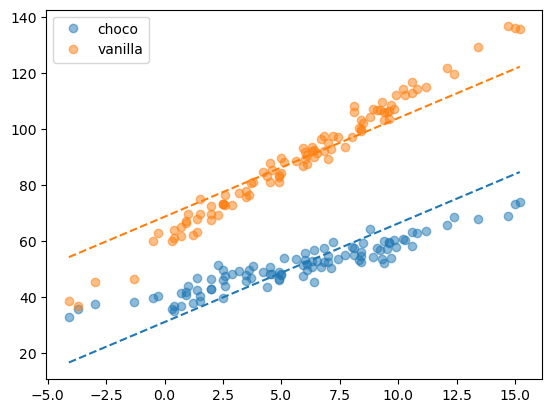

In [24]:
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales,'o',label='choco',color='C0',alpha=0.5)
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales_hat,'--',color='C0')
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales,'o',label='vanilla',color='C1',alpha=0.5)
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales_hat,'--',color='C1')
plt.legend()

> 이 모형은 초코/바닐라에 대한 기울기차이를 "표현"할 수 없다. 이러한 상황은 "모형의 표현력이 약하다" 혹은 "언더피팅"인 상황이라고 한다. 

# 6. 분석2 (교호작용항 추가)

`-` 모형을 아래와 같이 본다. 

- ${\bf X}$: `temp`, `type`, `temp` $\times$ `type`
- ${\bf y}$: `sales`

In [40]:
pd.get_dummies(df_train[['temp','type']],drop_first=True).eval('interaction = temp*type_vanilla')

temp  type_vanilla  interaction
0   -4.1         False         -0.0
1   -3.7         False         -0.0
2   -3.0         False         -0.0
3   -1.3         False         -0.0
4   -0.5         False         -0.0
..   ...           ...          ...
95  12.4          True         12.4
96  13.4          True         13.4
97  14.7          True         14.7
98  15.0          True         15.0
99  15.2          True         15.2

[200 rows x 3 columns]

In [28]:
# step1 
X = pd.get_dummies(df_train[['temp','type']],drop_first=True).eval('interaction = temp*type_vanilla')
y = df_train['sales']
# step2
predictr = sklearn.linear_model.LinearRegression()
# step3
predictr.fit(X,y)
# step4 
df_train['sales_hat'] = predictr.predict(X)

In [29]:
predictr.score(X,y)

0.9865793819066231

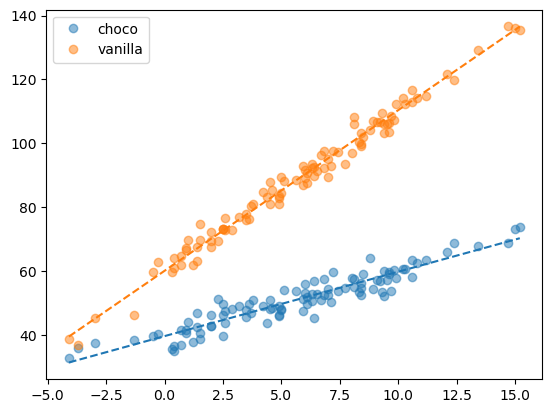

In [32]:
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales,'o',label='choco',color='C0',alpha=0.5)
plt.plot(df_train[df_train.type=='choco'].temp,df_train[df_train.type=='choco'].sales_hat,'--',color='C0')
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales,'o',label='vanilla',color='C1',alpha=0.5)
plt.plot(df_train[df_train.type=='vanilla'].temp,df_train[df_train.type=='vanilla'].sales_hat,'--',color='C1')
plt.legend()

기울기는 `temp`$\times$`type`의 인터럭션 텀으로 맞출 수 있게 되었다.

> Note: 초코/바닐라에 대한 절편차이는 `type`로, 초코/바닐라에 대한 기울기 차이는 `temp`$\times$`type`로 표현한다. 